In [1]:
import os
import glob
import json
import scipy
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme()
sns.set_context("paper")

import matplotlib.pyplot as plt

### i. Load experiment results from .json files

In [2]:
DATADIR = "./haid_experiment_data_files"

all_data = []
for path in glob.iglob(f"{DATADIR}/*.json"):
    with open(path, 'r') as f:
        jsonobj = json.load(f)
    all_data.append(jsonobj)

print("Number of participants (N): ", len(all_data))

# Ensure all responses are complete
assert all([d["waetresult"]["@state"] == "complete" for d in all_data])

Number of participants (N):  30


### ii. Extract, sort and perform relevant transformations on the .json data

##### Extract top-level reference information

In [3]:
META_DICT  = all_data[0]["waetresult"]
PAGES      = META_DICT["waet"]["page"]
PAGE_0     = PAGES[0]
SCALE_LABS = PAGE_0["interface"]["scales"]["scalelabel"]

STRVALUE_2_INSTR_DICT = {
    obj["@position"]: obj["#text"] for obj in SCALE_LABS
}

INSTR_2_LABEL_DICT = {
    instr: ix for ix, instr in 
        enumerate(STRVALUE_2_INSTR_DICT.values())
}

# Add auxillary keys to the transformation dict,
# to account for the variation in naming schemes
# between the file name (ground truth) and the label
# shown to the participant
INSTR_2_LABEL_DICT.update({
    "Bass"     : INSTR_2_LABEL_DICT["Double Bass"],
    "PianoLow" : INSTR_2_LABEL_DICT["Piano Low"],
    "PianoMid" : INSTR_2_LABEL_DICT["Piano Mid"],
    "PianoHigh": INSTR_2_LABEL_DICT["Piano High"]
})

INSTR_COUNTS = {
    k: 0 for k in INSTR_2_LABEL_DICT.keys()
}

print(STRVALUE_2_INSTR_DICT)
print(INSTR_2_LABEL_DICT)
print(INSTR_COUNTS)

{'0': 'Piano Low', '12': 'Piano Mid', '25': 'Piano High', '37': 'Double Bass', '50': 'Tuba', '62': 'Viola', '75': 'Oboe', '87': 'Violin', '100': 'Flute'}
{'Piano Low': 0, 'Piano Mid': 1, 'Piano High': 2, 'Double Bass': 3, 'Tuba': 4, 'Viola': 5, 'Oboe': 6, 'Violin': 7, 'Flute': 8, 'Bass': 3, 'PianoLow': 0, 'PianoMid': 1, 'PianoHigh': 2}
{'Piano Low': 0, 'Piano Mid': 0, 'Piano High': 0, 'Double Bass': 0, 'Tuba': 0, 'Viola': 0, 'Oboe': 0, 'Violin': 0, 'Flute': 0, 'Bass': 0, 'PianoLow': 0, 'PianoMid': 0, 'PianoHigh': 0}


##### Construct trial indexers to split results across experimental conditions (articulation, algo)

In [4]:
CONDITION0 = 'NoAlgo'
CONDITION1 = 'CompFreq'
CONDITION2 = 'Reinforced'
INTERACT0 = 'Staccato'
INTERACT1 = 'Legato'
INTERACT2 = 'Mix'

ALGOIX = 0
ARTIIX = 1
INSTIX = 2
algorithm_dict    = {}
articulation_dict = {}

for cur_page in PAGES:
    page_id   = cur_page["@id"]
    elem_info = cur_page["audioelement"]
    audio_id  = elem_info["@id"]
    cond_info = audio_id.split('_')    
    algorithm_dict[page_id]    = cond_info[ALGOIX]
    articulation_dict[page_id] = cond_info[ARTIIX]
    INSTR_COUNTS[cond_info[INSTIX]] += 1
    
algorithm_sr    = pd.Series(data=algorithm_dict   , name="Algorithm")
articulation_sr = pd.Series(data=articulation_dict, name="Articulation")
print(INSTR_COUNTS)

{'Piano Low': 0, 'Piano Mid': 0, 'Piano High': 0, 'Double Bass': 0, 'Tuba': 9, 'Viola': 9, 'Oboe': 9, 'Violin': 9, 'Flute': 9, 'Bass': 9, 'PianoLow': 9, 'PianoMid': 9, 'PianoHigh': 9}


##### Construct a comparison matrix with ground-truth values across all trials 

In [5]:
NTRIALS = len(META_DICT["waet"]["page"])
NINSTR  = len(STRVALUE_2_INSTR_DICT)

COMPARISON_DICT = {}
PAGES = META_DICT["waet"]["page"]
for cur_page in PAGES:
    page_id   = cur_page["@id"]
    elem_info = cur_page["audioelement"]
    audio_id  = elem_info["@id"]
    cur_instr = audio_id.split('_')[INSTIX]
    instr_lab = INSTR_2_LABEL_DICT[cur_instr]
    
    truth_array = [
        1 if i is instr_lab else 0 
            for i in range(NINSTR)
    ]
    
    COMPARISON_DICT[page_id] = truth_array
    
COMPARISON_DF = pd.DataFrame.from_dict(
    COMPARISON_DICT, 
    orient='index', 
    columns=STRVALUE_2_INSTR_DICT.values()
)
COMPARISON_DF

,Piano Low,Piano Mid,Piano High,Double Bass,Tuba,Viola,Oboe,Violin,Flute
page_0,0,0,0,1,0,0,0,0,0
page_1,0,0,0,0,0,0,0,0,1
page_2,0,0,0,0,0,0,1,0,0
page_3,0,0,1,0,0,0,0,0,0
page_4,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
page_76,1,0,0,0,0,0,0,0,0
page_77,0,1,0,0,0,0,0,0,0
page_78,0,0,0,0,1,0,0,0,0
page_79,0,0,0,0,0,1,0,0,0


### 1.0 Prepare Participants Results

##### 1.1 Setup Helper functions 

In [6]:
def DataFrame_zeros_like(df):
    return df.applymap(lambda x: 0)

def make_guess_dataframe(results_dict):
    # Construct an empty DataFrame with the same index/column...
    # size and labels of `COMPARISON_DF`
    guess_df = DataFrame_zeros_like(COMPARISON_DF)
    
    # Instantiate a list to store trial states
    trial_states = []
    
    # Iterate over every trial and update the empty...
    # DataFrame with the corresponding participants guess
    for trial in results_dict:
        # Extract which trial is referenced
        trial_ref = trial["@ref"]
        
        # Extract completion state
        state = trial["@state"]
        trial_states.append(state == "complete")
        
        # Extract participants response... 
        # (encoded value btw. 0.17 - 1.0)
        response_enc = trial["audioelement"]
        response_enc = float(response_enc["value"])
        response_enc = int(response_enc * 100.)
        response_dec = str(response_enc)
        
        # Get the instrument string label of the response
        instr_label = STRVALUE_2_INSTR_DICT[response_dec]
        
        # Update the correct row/col of the DataFrame
        guess_df.at[trial_ref, instr_label] = 1
        
    # Return the DataFrame for this participant..
    # along with the completion states for each trial
    return guess_df, trial_states

##### 1.2 Compute amount of correct/wrong answers and accumulate into a single DataFrame 

In [7]:
responses = []
responses_instr = []
responses_stats = []

for ix, data_dict in enumerate(all_data):
    data = data_dict["waetresult"]
    data = data["page"]
    
    res, states = make_guess_dataframe(data)
    assert all(states)
    
    match_df = COMPARISON_DF * res
    match_df_agg = match_df.join([algorithm_sr, articulation_sr])
    match_df_agg = match_df_agg.groupby(
        ['Algorithm', 'Articulation']
    ).sum()
    responses_instr.append(match_df_agg)
    responses.append(match_df_agg.sum(axis=1))
    
    analysis_df = match_df.join(algorithm_sr).groupby(
        ['Algorithm']
    ).sum().sum(axis=1)
    
    responses_stats.append(analysis_df)
    
    
agg_responses_df = pd.DataFrame().append(responses).T
agg_responses_instr_df = pd.DataFrame().append(responses_instr)
agg_analysis_df = pd.DataFrame().append(responses_stats)

##### 1.3 Make some pretty plots 

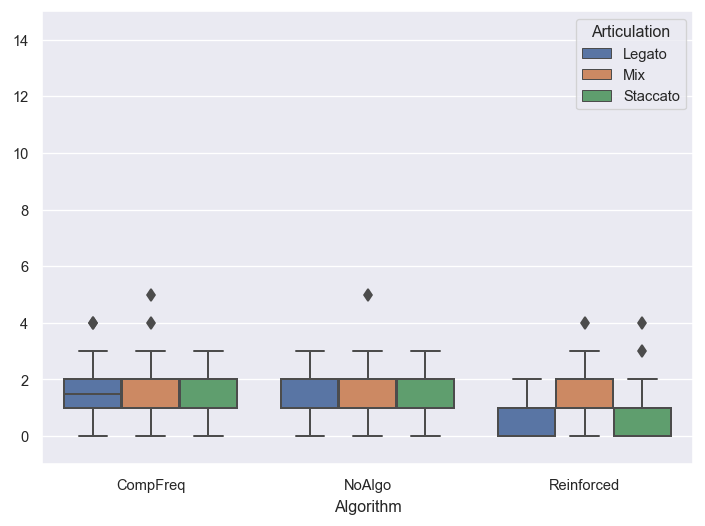

In [8]:
sns_bp_df = agg_responses_df.reset_index().melt(id_vars=[
    'Algorithm', 'Articulation'
], value_name='Amount Correct Responses')

fig, ax = plt.subplots(1, dpi=120, figsize=(7, 5))
bp = sns.boxplot(
    data=sns_bp_df, 
    x='Algorithm', 
    y='Amount Correct Responses', 
    hue='Articulation',
    ax=ax
)
plt.ylim(-1, 15)
ax.set(ylabel=None)
plt.show()

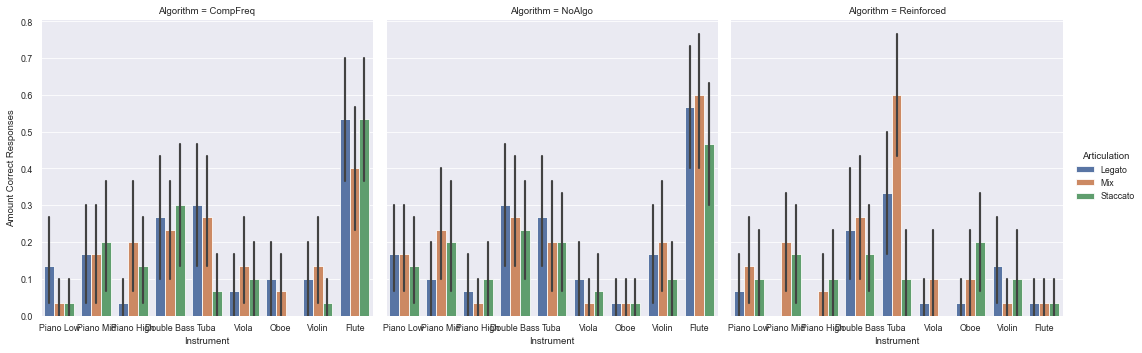

In [9]:
sns_cp_df = agg_responses_instr_df.reset_index().melt(id_vars=[
    'Algorithm', 'Articulation'
], value_name='Amount Correct Responses', var_name='Instrument')


cp = sns.catplot(
    data=sns_cp_df,
    kind="bar",
    col='Algorithm',
    y='Amount Correct Responses',
    x='Instrument',
    hue='Articulation',
    #col_wrap=4
)

##### 1.4 Perform statistical tests

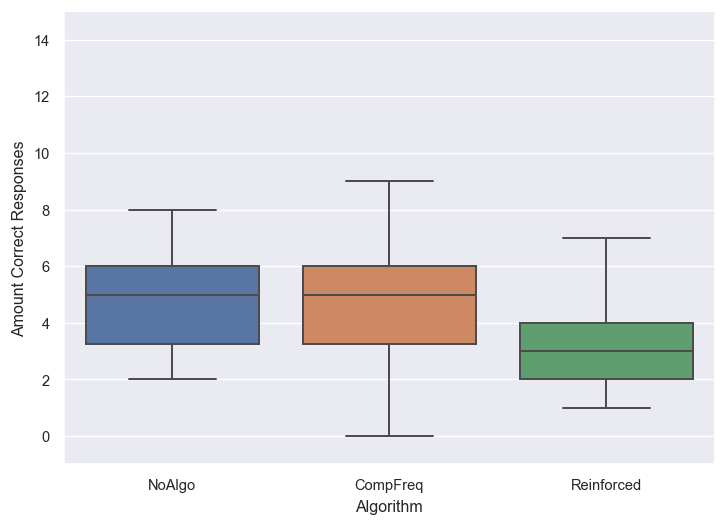

In [10]:
agg_analysis_df_ro = agg_analysis_df[[CONDITION0, CONDITION1, CONDITION2]]

fig, ax = plt.subplots(1, dpi=120, figsize=(7, 5))
bp = sns.boxplot(
    data=agg_analysis_df_ro, 
    ax=ax
)

plt.ylim(-1, 15)
ax.set(ylabel='Amount Correct Responses')
plt.show()

### Fetch Conditions 

In [11]:
c0 = agg_analysis_df[CONDITION0].to_numpy()
c1 = agg_analysis_df[CONDITION1].to_numpy()
c2 = agg_analysis_df[CONDITION2].to_numpy()
print("Data Shapes:")
print(c0.shape, c1.shape, c2.shape)

# Compute the medians of each condition
mdn0 = np.median(c0)
mdn1 = np.median(c1)
mdn2 = np.median(c2)
print("\nMedians:")
print(f"[{CONDITION0}: {mdn0}]", f"[{CONDITION1}: {mdn1}]", f"[{CONDITION2}: {mdn2}]")

Data Shapes:
(30,) (30,) (30,)

Medians:
[NoAlgo: 5.0] [CompFreq: 5.0] [Reinforced: 3.0]


### Friedman "ANOVA" 

In [12]:
fm_stat, fm_p = scipy.stats.friedmanchisquare(c0, c1, c2)
print("FM ANOVA Result:")
print(f"[Stat: {fm_stat:.4f}]", f"[p: {fm_p:.4f}]")

FM ANOVA Result:
[Stat: 9.0192] [p: 0.0110]


##  Post-hoc Wilcoxon Signed Rank Test
<b>(Non-parametric equivalent to dependent t-test)</b>

In [13]:
def wilcoxon_extra(x, y, alt='two-sided'):
    wsr_stat, wsr_p = scipy.stats.wilcoxon(
        x = x,
        y = y,
        mode = 'auto',
        alternative = alt
    )
    wsr_z = scipy.stats.norm.isf(wsr_p / 2) # Retrieve z-score from p-value
    wsr_r = wsr_z / np.sqrt(len(x)*2)       # Retrieve effect-size from z-score
    return wsr_stat, wsr_p, wsr_z, wsr_r

def format_wilcoxon(wres):
    T, p, z, r = wres
    out_format = (
        f"[Stat: {T:.4f}]",
        f"[p: {p:.4f}]",
        f"[z: {z:.4f}]",
        f"[r: {r:.4f}]"
    )
    return out_format

#####  Check if difference in medians btw NoAlgo and CompFreq

In [14]:
wres0 = wilcoxon_extra(c0, c1)
pformat = format_wilcoxon(wres0)

print("Cond: NoAlgo v. CompFreq")
print(*pformat)

Cond: NoAlgo v. CompFreq
[Stat: 118.0000] [p: 0.3553] [z: 0.9243] [r: 0.1193]


#####  Check if difference in medians btw NoAlgo and Reinforced

In [15]:
wres1 = wilcoxon_extra(c0, c2)
pformat = format_wilcoxon(wres1)

print("Cond: NoAlgo v. Reinforced")
print(*pformat)

Cond: NoAlgo v. Reinforced
[Stat: 66.0000] [p: 0.0030] [z: 2.9722] [r: 0.3837]


#####  Check if difference in medians btw CompFreq and Reinforced

In [16]:
wres1 = wilcoxon_extra(c1, c2)
pformat = format_wilcoxon(wres1)

print("Cond: Compfreg v. Reinforced")
print(*pformat)

Cond: Compfreg v. Reinforced
[Stat: 58.0000] [p: 0.0081] [z: 2.6492] [r: 0.3420]
